<a href="https://colab.research.google.com/github/nicolasrondan/cv-um-2021/blob/main/practico-3/Pra%CC%81ctico_3_Keypoints_Descriptores_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Montar Google Drive ####

In [ ]:
#@title 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2021/practico-3/

In [ ]:
! pip install -e ../cvum

# PRACTICO 3 - PUNTOS DE INTERES, DESCRIPTORES Y MATCHING

En este práctico vamos a estudiar distintos algoritmos para extraer puntos de interes (*keypoints*) y representarlos en descriptores. Además, se estudiará un caso simple de como hacer una correspondencia de puntos (*matching*) entre imágenes.

Para ello vamos a trabajar en tres secciones:
1. **Detector de Harris**: Implementar el algoritmo de detección de esquinas de harris utilizando el esqueleto de código.
2. **Calculo de descriptores para puntos de interés**: Implementar dos algoritmos de cálculo de descriptores utilizando los esqueletos de código y analizar la correspondecia de puntos.
3. **Alineación de imágenes en base a puntos de interes**: Calcular la transformación que lleva de image imagen a otra utilizando puntos de interes y correspondencia entre puntos.

## 1. Detector de Harris

En esta sección vamos a implementar una versión simple del detector de Harris, para ello vamos a utilizar un esqueleto de código como referencia. El objetivo es cargar una imagen, aplicar el detector de Harris  e imprimir los puntos resultantes sobre la imagen original.
El procedimiento para aplicar el detector de Harris como vimos en clase es el siguiente: 


1.   Calcular el gradiente de la imagen en cada dirección
2.   Luego calculamos la matriz de Harris en cada punto y el score de Harris en cada punto.
3.   Umbralizar el score de Harris y definir cuales son detecciones válidas

Un resumen de estos pasos se puede encontrar en el la sección 4.1.1 del [libro Szeliski](https://szeliski.org/Book/drafts/SzeliskiBook_20100903_draft.pdf).

En la siguiente imagen se hace un repaso de estos pasos. En este caso por simplicidad se pide implementar el algoritmo calculando el score de Harris en cada punto (pointwise) en vez de hacer una sumatoria sobre una ventana local.


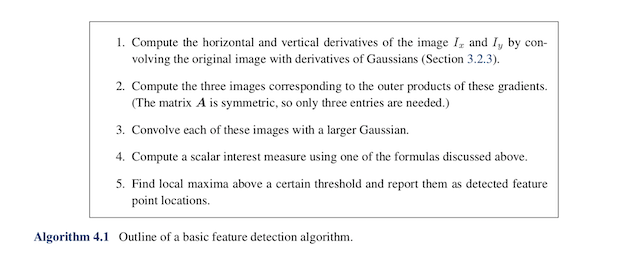

El resultado debería ser similar a la Figura:

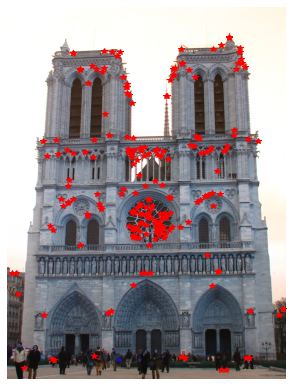


Se pueden comparar estos resultados a los obtenidos utilizando la función cv2.cornerHarris() de OpenCV.



**[Opcional]**     
El proceso de implementar la detección de Harris implica hacer un loop que itere por todos los puntos de una imagen para calcular la matriz de Harris y el score de Harris. Implementar una versión del algoritmo anterior que utilice operaciones de vectores. Las operaciones de vectores y matrices están optimizadas en Numpy (también en numpy, scipy y otros paquetes de Python), lo cual acelera el procesamiento de estás operaciones y evita los loops que pueden ser operaciones costosas.

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Tuple, List


In [12]:
mpl.rc('axes.spines',top=False,bottom=False,left=False,right=False);
mpl.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
mpl.rc(('xtick','ytick'),color=(1,1,1,0));
mpl.rc('figure', figsize=(20,10))

In [ ]:
## read input image
img_raw = cv2.imread('images/part1.jpg')
img_raw = cv2.resize(img_raw,(0,0), fx=0.5, fy=0.5)

## write a Harris detector
# compute the Ix,Iy,Iy

# grayscale the image
img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)

# apply gaussian filter to the image
img = cv2.GaussianBlur(img,(5,5),0.1)

#Ix= ....    #generate the Ix image 

#Iy= ....    #generate the Iy image
#IxIy=  .... #generate Ix*Iy image


sigma = 0.3

#apply gaussian filter for three new images
Ix= cv2.GaussianBlur(Ix,(5,5),sigma)
Iy= cv2.GaussianBlur(Iy,(5,5),sigma)
IxIy= cv2.GaussianBlur(Ixy,(5,5),sigma)

plt.figure(figsize=(20,8))
plt.imshow(np.concatenate([Ix,Iy,IxIy], axis=1), cmap='gray',vmax=650,vmin=-650)
plt.axis('off')
plt.title('Gradient Images Ix, Iy, IxIy')
plt.show()

#computer the Harris score for each points in the picture
alpha = 0.06 #according to the original paper

x,y = img.shape
harris_img = np.zeros([x,y])

for i in range(0,x):
    for j in range(0,y):
      #harris_matrix = np.array([[Ix[i,j]**2,Ix[i,j]*Iy[i,j]],[Ix[i,j]*Iy[i,j],(Iy[i,j])**2]]) #create the Harris matrix
      # use numpy functions to compute determinant and trace.
      #compute the Harris score using the formula provided in the course
      #save the Harris score in the harris_img matrix for plotting.


plt.figure(figsize=(5,8))
plt.imshow(harris_img, cmap='Blues')
plt.axis('off')
plt.title('Harris Score Image')
plt.show()
    
# Plot 
# set the threshold here

R = 0.01*harris_img.max()
coordinates = np.argwhere(harris_img > R)
ip_x = coordinates[:,0]
ip_y = coordinates[:,1]
plt.figure(figsize=(5,8))
plt.imshow(img_raw)
plt.axis('off')
plt.plot(ip_y,ip_x,'r*');




## 2. **Correspondencia de Puntos**

En esta sección vamos a utilizar las funcion de OpenCV `cornerHarris()` para obtener puntos de interes en una imagen y realizar la correspondencia entre puntos de dos imágenes muy similares. Para ello vamos a utilizar un esqueleto de código con un flujo predefinido y para que funciones correctamente es necesario implementar varas funciones auxiliares. 

En la primera parte se lee una imagen y se le aplica una traslación y se escala la imagen levemente para tener un mismo objeto pero en distintas posiciones en cada imagen. El objetivo de esta sección es: 

1. Implementar las funciones `extract_appearance_descriptor()` y `extract_gradient_descriptor()` para extraer descriptores. La primera de ellas extrae descriptores basados en un parche de color y la segunda extrae descriptores basados en un histograma de gradientes.
2. Implementar la función `match_descriptors()` para detectar correspondencias entre los descriptores. 

Asumiendo que se detectaron N puntos de interes será necesario implemetar las siguientes funciones auxiliares:

### 2.1 Implementación de Funciones


#### 2.1.1 ***extract_appearance_descriptor***:

Esta función toma como entrada un array de ${N \times 2}$ conteniendo las coordenadas de los puntos de interes y devuelve a la salida una matriz de tamaño ${N \times Patchsize}$ donde cada fila representa el vector de pixeles del parche centrado en cada punto de interes. Esta función se utilizara para describir un punto con un parche de __apariencia__ de la image. Tambien es necesario controlar si todos los puntos son validos y devolver una lista de puntos válidos.

In [7]:
def extract_appearance_descriptor(image:np.ndarray,keypoints:np.ndarray)-> Tuple[np.ndarray,List[np.ndarray]]:
    """Extracts descriptors based on image color patch given a set of 
    keypoints on the image. Only calculate descriptors for valid points

    Args:
        image: grayscale input image.
        keypoints: feature points detected on the image.

    Returns:
        Tuple containing an array of appearance descriptors containing one descriptor per 
        valid keypoint and a List of valid keypoints

    """
    if image.dtype == np.uint8:
        image = image / 255. 
    image_height, image_width = image.shape
    num_keypoints , _ = keypoints.shape 
    valid_points = [] # create list of valid_points
    colour_descriptors = [] # create list of descriptors

  
    return colour_descriptors, valid_points

#### 2.1.2 ***extract_gradient_descriptor***:
Esta función toma como entrada un array de ${N \times 2}$ conteniendo las coordenadas de los puntos de interes y devuleve una matriz de tamaño ${N \times Histsize}$ representando el histograma de gradientes en cada parche alrededor de los puntos de interes. Se pueden utilizar la función [histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) de numpy. También se puede utilizar la función `calculate_image_gradient` incluida en el paquete cvum con utilidades para el curso.


In [ ]:
from cvum.utils import calculate_image_gradient

In [8]:
def extract_gradient_descriptor(image:np.ndarray,keypoints:np.ndarray)-> Tuple[np.ndarray,List[np.ndarray]]:
    """ Extracts descriptors based on image gradients given a set of 
    keypoints on the image. Only calculate descriptors for valid points.
    The descriptor is composed by a histogram of gradients for the patch
    around the keypoint.

    Args:
        image: grayscale input image.
        keypoints: feature points detected on the image.

    Returns:
        Tuple containing an array of gradient descriptors containing one descriptor per 
        valid keypoint and a List of valid keypoints

    """ 
    if image.dtype == np.uint8:
        image = image / 255. 
    image_height, image_width = image.shape
    num_keypoints , _ = keypoints.shape 
    valid_points = [] # create list of valid_points
    histogram_bins = np.arange(-np.pi,np.pi,np.pi/6)
    gradiend_descriptors = []


  
    #gradient_hist = ...
    return gradiend_descriptors, valid_points


#### 2.1.3 ***match_descriptors***
Esta función toma como entrada una matriz de descriptores para cada imagen y devuelve una lista de tamaño ${N \times 1}$ que define para cada punto de interes cual es el correspondiente en la segunda imagen. (Hint: investigar la función [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) de scipy aplicarla entre los descriptores y visualizarla en una imagen).


In [9]:
def match_descriptors(descriptors_left:np.ndarray, descriptors_right:np.ndarray, threshold=5) -> List[int]:
    """ Computes de distances between two sets of descriptors and returns 
    the closest match under a given distance threshold. 

    Args:
        descriptors_left: first set of descriptors.
        descriptors_right:  second set of descriptors.
        threshold: distance threshold to define if closest match is a true match.

    Returns:
        List containing indexes of the correspoding descriptor match given 
        the list index for the left set of descriptors. If no match is found
        index is set as -1 for that descriptor.

    """  
    threshold_distance = threshold
    distances = cdist(descriptors_left, descriptors_right)
    num_descriptors_left = distances.shape[0]
    
    matches_list = np.zeros(descriptors_left.shape[0])
    
    return matches_list

#### 2.1.4 Resultado Esperado

Una vez completadas las funciones se puede correr el código de la **Parte 2**. El resultado debería ser similar al de las siguientes Figuras donde en la fila superior se visualiza la detección de puntos y en la siguiente el resultado de hacer las correspondencias entre puntos



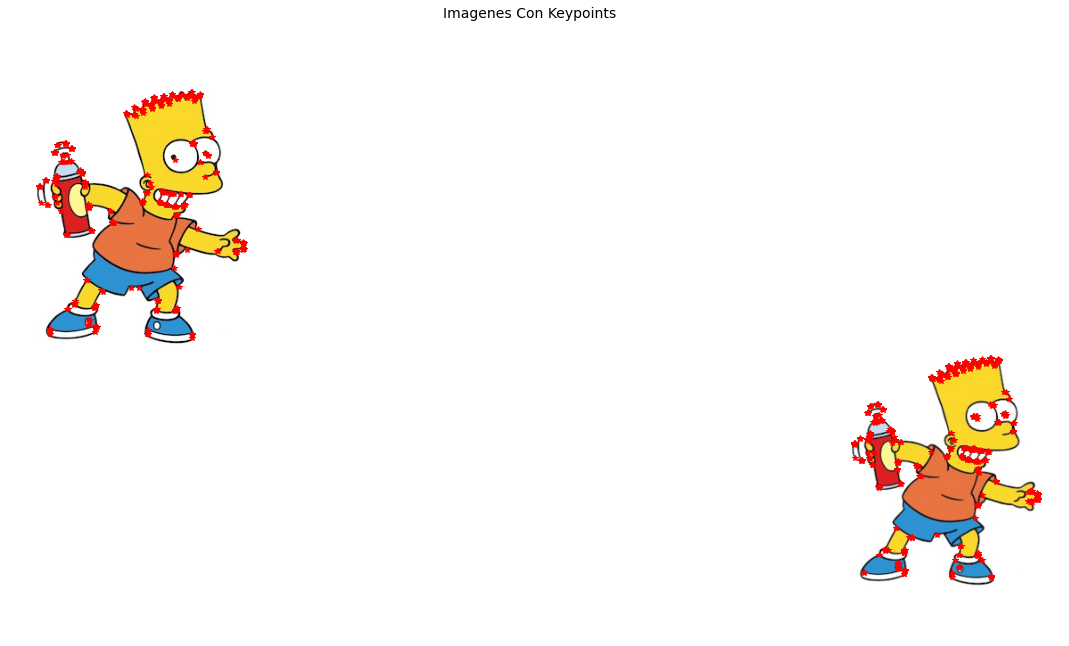



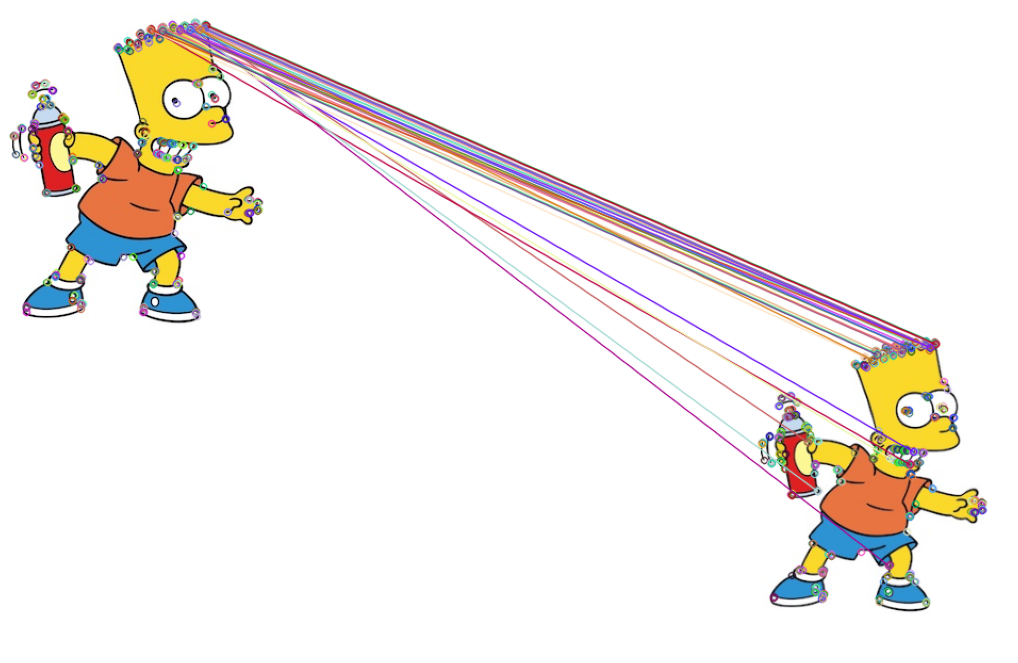

### Parte 2.2 Visualización de Resultados




#### 2.2.1 Cargar Imagen y Transformala
En esta sección vamos a cargar una imagen de bart simpson escalarla levemente y trasladarla geométricamente para generar una nueva imagen.

In [ ]:
## part 2 Interset Point Description & Matching
# Create two images by translating one image.

input_image = cv2.imread('images/barta.jpg')
input_image = cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)
image_width = input_image.shape[1]
image_height = input_image.shape[0]
#Generate white image same size as original
z = 255*np.ones(input_image.shape, dtype=np.uint8)

#Concat white matrix with original image
#Scale image by desider scale
scale = 0.9
affine_transform = np.array([[scale,0,0],[0,scale,0]])
scaled_image = cv2.warpAffine(input_image,affine_transform,dsize=(image_width, image_height),borderValue=(255,255,255))
image_left = np.vstack([np.hstack([input_image,z]),np.hstack([z,z])]) #original image on upper left corner
image_right = np.vstack([np.hstack([z,z]),np.hstack([z,scaled_image])]) #original image on bottom right corner

#Add padding so that every point has a complete patch around
image_left = cv2.copyMakeBorder(image_left, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=(255,255,255))
image_right = cv2.copyMakeBorder(image_right, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=(255,255,255))#original image on bottom right corner

fig = plt.gcf()
fig.suptitle("Imagenes Originales", fontsize=14)
plt.subplot(121)
plt.imshow(image_left)
plt.subplot(122)
plt.imshow(image_right)
plt.show()

#### 2.2.2 Calcular los keypoints para cada imagen
Se calculan los keypoints de ambas imágenes utilizando la función de respuesta a las esquinas de Harris implementada en Opencv [`cornerHarris()`](https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html)

In [ ]:
# grayscale left image 
image_left_gray = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
#detect corners for left image
keypoints_left = cv2.cornerHarris(image_left_gray,2,3,0.04)
# grayscale right image 
image_right_gray = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)
# detect corners for right image
keypoints_right = cv2.cornerHarris(image_right_gray,2,3,0.04)

# Transform the image with harris score into keypoint locations
keypoints_loc_left = np.argwhere(keypoints_left > 0.1*keypoints_left.max())
keypoints_loc_right = np.argwhere(keypoints_right > 0.1*keypoints_right.max())

fig = plt.gcf()
fig.suptitle("Imagenes Con Keypoints", fontsize=14)
plt.subplot(121)
plt.imshow(image_left)
plt.plot(keypoints_loc_left[:,1],keypoints_loc_left[:,0], '*r')
plt.subplot(122)
plt.imshow(image_right)
plt.plot(keypoints_loc_right[:,1],keypoints_loc_right[:,0], '*r')
plt.show()

#### 2.2.3 Descriptores basados en color
En esta sección vamos a validar los descriptores basados en color y la matriz de distancia entre ellos. Vamos a analizar como se interpreta la matriz de distancias.

In [15]:
from scipy.spatial.distance import cdist

In [ ]:
#extract appearance patch descriptor
print('Calculating Left Descriptors ...')
colour_descriptors_left, valid_points_l = extract_appearance_descriptor(image_left_gray,keypoints_loc_left);
print('Calculating Right Descriptors ...')
colour_descriptors_right, valid_points = extract_appearance_descriptor(image_right_gray,keypoints_loc_right);
colour_descriptors_left = np.asarray(colour_descriptors_left)
colour_descriptors_right = np.asarray(colour_descriptors_right)

# Since the image content is equal in both images the descriptors will be equal
print('Equal descriptors {}'.format(np.all(colour_descriptors_left==colour_descriptors_right)))

#### 2.2.4 Matriz de distancia entre descriptores
1. Primero analizemos como se interpreta la matriz de distancias si calculamos las distancias de los descriptores de la imagen izquierda consigo mismos.

Al visualizar esta primera imagen la diagonal deberías ser completamente zero ya que la distancia de cada vector descriptor consigo mismo es cero. El resto de los puntos de la matriz deberían tener algún valor distinto de cero.

2. Visualizemos la matriz de distancias entren los descriptores de la imagen izquierda y los de la derecha. En algunos puntos 

In [ ]:
import seaborn as sns
## Use seaborn to visualize the distance between descriptors of keypoints in both images
## The diagonal should be black because every both set of descriptors are equal (both images have the same content at each point)
D = cdist(colour_descriptors_left,colour_descriptors_left)
with plt.style.context('seaborn-dark'):
    sns.heatmap(D)
    plt.show()

In [ ]:
import seaborn as sns
## Use seaborn to visualize the distance between descriptors on both images
D = cdist(colour_descriptors_left,colour_descriptors_right)
with plt.style.context('seaborn-dark'):
    sns.heatmap(D)
    plt.show()

#### 2.2.5 Correspondencia entre puntos de interes 

In [ ]:
# Match descriptors and draw matches with same colour
match_list_colour = match_descriptors(colour_descriptors_left,colour_descriptors_right,threshold=0.5)

In [ ]:
opencv_keypoints_left = [cv2.KeyPoint(float(y),float(x),3) for x, y in keypoints_loc_left]
opencv_keypoints_right = [cv2.KeyPoint(float(y),float(x),3) for x, y in keypoints_loc_right]

In [ ]:
opencv_matches_colour = [[cv2.DMatch(idx, int(match_idx), 3)] for idx, match_idx in enumerate(match_list_colour) if match_idx > 0]

In [ ]:
points_limit = 50
opencv_matches_colour = opencv_matches_colour[:points_limit]

In [ ]:
image_matches_c = cv2.drawMatchesKnn(image_left,opencv_keypoints_left,image_right,opencv_keypoints_right,opencv_matches_colour,None)
plt.figure(figsize=(18,18))
plt.axis('off')
plt.imshow(image_matches_c)

#### 2.2.6 Descriptor de Gradientes


In [ ]:
gradient_descriptors_left, valid_points_l = extract_gradient_descriptor(image_left_gray,keypoints_loc_left)
gradient_descriptors_right, valid_points_r = extract_gradient_descriptor(image_right_gray,keypoints_loc_right)
gradient_descriptors_left = np.asarray(gradient_descriptors_left)
gradient_descriptors_right = np.asarray(gradient_descriptors_right)

# Since the image content is equal in both images the descriptors will be equal
print('Equal descriptors {}'.format(np.all(gradient_descriptors_left==gradient_descriptors_right)))
# Match descriptors

In [ ]:
gradient_descriptors_left.shape

In [19]:
gradient_descriptors_right.shape

(0,)

In [ ]:
match_list_gradient = match_descriptors(gradient_descriptors_left,gradient_descriptors_right,threshold=5)

In [ ]:
opencv_matches_gradient = [[cv2.DMatch(idx, int(match_idx), 3)] for idx, match_idx in enumerate(match_list_gradient) if match_idx>0]

In [ ]:
points_limit = 50
opencv_matches_gradient = opencv_matches_gradient[:points_limit]

In [ ]:
image_matches_g = cv2.drawMatchesKnn(image_left,opencv_keypoints_left,image_right,opencv_keypoints_right,opencv_matches_gradient,None)
plt.figure(figsize=(18,18))
plt.axis('off')
plt.imshow(image_matches_g)

#  Alineación de imágenes con RANSAC


En esta sección vamos a utilizar RANSAC para estimar de forma robusta la transformación afín entre dos imágenes. Para esta sección se provee un esqueleto de código que realiza los siguientes pasos:

1. Lee dos imágenes
2. Detecta puntos de interes (Utilizando el un detector de puntos de interes, vamos a utilizar BRISK que es un extractor de puntos incluido por defecto en OpenCV )
3. Describe los puntos utilizando la funcion `detectAndCompute()` que nos devuelve puntos de interes y su descriptor asociado
4. Hacer la correspondencia entre puntos usando un "*BruteForce*" matching. 
5. Calcula la transformación afín y hace la alineación de las imágenes utilizando mínimos cuadrados. 

Como vimos en clase esto no es suficientemente robusto. Por este motivo, se pide implementar un loop RANSAC que sea capaz de estimar la transformación afín  entre dos imágenes de manera robusta. Esta función debe devolver una matriz M de *3 × 2* que transforma cada punto X1 de la imagen 1 a sus correspondientes puntos X2 de la imagen 2, de manera que X2 = M * X1 genera la mayor cantidad de inliers en la transformación.

Recuerden que RANSAC toma un subset de puntos para cada iteración del loop y calcula la transformación que transforma los puntos X1 del subset en los puntos X2 del subset. Luego repite este procedimiento un número definido de veces hasta encontrar la transformación que genera más inliers en el set completo de puntos de interes.


Como último objetivo se pide generar un imagen panorama utilizando las dos imágenes alineadas.

### Cargar las Imágenes

In [ ]:
import os
image1 = 'images/part3_1.JPG'
image2 = 'images/part3_2.JPG'

In [ ]:
img1 = cv2.imread(image1,cv2.IMREAD_GRAYSCALE)         
img2 = cv2.imread(image2,cv2.IMREAD_GRAYSCALE) # trainImage
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(img1,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2,cmap='gray')
plt.show()


### Detectar Puntos de Interes y Calcular sus Descriptores



In [ ]:
# Initiate ORB detector
detector = cv2.BRISK_create()
# find the keypoints and descriptors with ORB
kp1, des1 = detector.detectAndCompute(img1,None)
kp2, des2 = detector.detectAndCompute(img2,None)


### Hacer la correspondencia de Puntos

In [ ]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

### Dibujar Matches

In [ ]:
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good[:30],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(18,18))
plt.axis('off')
plt.imshow(img3)


### Estimar la transformación: Mínimos cuadrados


In [ ]:
# Extract location of good matches
points1 = np.zeros((len(good), 2), dtype=np.float32)
points2 = np.zeros((len(good), 2), dtype=np.float32)

for i, match in enumerate(good):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt


In [ ]:
### YOUR CODE TO ESTIMATE THE TRANSFORMATION
#transform_matrix = ...

In [ ]:
rows,cols = img1.shape

dst = cv2.warpAffine(img1,transform_matrix.T,(cols,rows))

In [ ]:
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(img1,cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(dst,cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img2,cmap='gray')
plt.axis('off')
plt.show()

#### Visualizar el Resultado

In [ ]:
mask = ~(dst > 0)
masked = cv2.bitwise_and(img2, img2, mask=mask.astype(np.uint8))
stitch = dst + masked

In [ ]:
plt.imshow(stitch, cmap='gray')

### Minimos cuadrados con ruido

El ejemplo anterior funcionó bastante bien, ahora hagamos el intento agregando ruido a los puntos.

In [ ]:
noise1 = np.random.uniform(0,683,1000);
noise2 = np.random.uniform(0,1024,1000);

k = 5;
noise1 = np.random.choice(noise1, k);
noise2 = np.random.choice(noise2, k);
noise = np.vstack([noise1,noise2]).T;

num,_ = points1.shape;

index_rand = np.random.choice(range(0,num),k*8);
points1 = points1[index_rand,:];
points2 = points2[index_rand,:];

points1 = np.vstack([points1,noise]);
points2 = np.vstack([points2,noise]);

In [ ]:
#Minimos cuadrados nuevamente
### YOUR CODE TO ESTIMATE THE TRANSFORMATION
#transform_matrix = ...

In [ ]:
rows,cols = img1.shape
dst = cv2.warpAffine(img1,transform_matrix.T,(cols,rows))

In [ ]:
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(img1,cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(dst,cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img2,cmap='gray')
plt.axis('off')

#### Visualizar el Resultado

In [ ]:
mask = ~(dst > 0)
masked = cv2.bitwise_and(img2, img2, mask=mask.astype(np.uint8))
stitch = dst + masked
plt.imshow(stitch, cmap='gray')

### *RANSAC*

En la funcion `ransac_loop_affine` se pide calcular la transformación afín utilizando un loop ransac sobre los puntos con ruido.

In [ ]:
def ransac_loop_affine(points1,points2, iterations,k=6, threshold_distance=0.05):
    transform_matrix=[]
    return transform_matrix

In [ ]:
transform_matrix = ransac_loop_affine(points1,points2,1500,k=6, threshold_distance=1) #Img1 points, Img2 points, Number of RANSAC iterations.
rows,cols = img1.shape
dst = cv2.warpAffine(img1,transform_matrix.T,(cols,rows))

In [ ]:
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(img1,cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(dst,cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img2,cmap='gray')
plt.axis('off')
plt.show()

#### Visualizar el Resultado

In [ ]:
mask = ~(dst > 0)
masked = cv2.bitwise_and(img2, img2, mask=mask.astype(np.uint8))
stitch = dst + masked
plt.imshow(stitch, cmap='gray')
plt.show()

# [OPCIONAL] Escribir código para hacer panorama stitching hint: [link text](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html)